In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib, vc_protocols
import mod_trace
from ord2011 import ORD2011

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
'''
O'Hara-Rudy CiPA v1.0 (2011)
'''
cells = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
current_li = ['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1']

protocol = vc_protocols.hERG_CiPA()
# protocol = pickle.load(open("./trial_steps_ramps_Kernik_200_50_4_-120_60_paper/shortened_trial_steps_ramps_Kernik_200_50_4_-120_60_500_artefact_True_short.pkl", 'rb'))
protocol = pickle.load(open("./trial_steps_ramps_ORD2011_288_51_4_-121_61/shortened_trial_steps_ramps_ORD2011_288_51_4_-121_61_500_artefact_False_short.pkl", 'rb'))

end_time = protocol.get_voltage_change_endpoints()[-1]
t_span = (0, end_time)
t_eval = np.linspace(0, end_time, 10000)
print(end_time)

6518.421250184367


In [3]:
start_time = time.time()

import simulator_myokit
'''
Simulation with Myokit
'''
model_path = "../mmt-model-files/ord-2011_VC.mmt" 
model_myokit, protocol_myokit, script = myokit.load(model_path)
sim_myokit = simulator_myokit.Simulator(model_myokit, protocol, max_step=1.0, abs_tol=1e-8, rel_tol=1e-8, vhold=-80.0) # 1e-12, 1e-14 # 1e-08, 1e-10  # max_step=1, atol=1E-2, rtol=1E-4 # defalt: abs_tol=1e-06, rel_tol=0.0001
sim_myokit.name = "ORD2011"
sim_myokit.simulation.set_constant('cell.mode', cells['Epicardial'])    
y0_myokit = sim_myokit.pre_simulate(5000, sim_type=1)
d_myokit = sim_myokit.simulate(end_time, log_times=None, extra_log=current_li)
   
print("--- %s seconds ---"%(time.time()-start_time))

--- 16.05409049987793 seconds ---


In [4]:
protocol.get_voltage_at_time(0)

-80

In [5]:
import simulator_scipy
'''
Simulation with Scipy
'''
model_scipy = ORD2011(protocol)
sim_scipy = simulator_scipy.Simulator(model_scipy)

start_time = time.time()

model_scipy.cell.mode = cells['Epicardial']
# model_scipy.y0[1:] = y0_myokit
y0 = sim_scipy.pre_simulate( pre_step=5000, protocol='constant' )   
sol_scipy = sim_scipy.simulate(t_span=t_span, t_eval=None, method='BDF', max_step=1.0, atol=1e-8, rtol=1e-8) # 1e-12, 1e-14  # 1e-08, 1e-10  # max_step=1, atol=1E-2, rtol=1E-4 # defalt: abs_tol=1e-06, rel_tol=0.001
# sol_scipy = sim_scipy.simulate2( t_eval, max_step=1e-5*100000, atol=1e-08, rtol=1e-10) # 1e-12, 1e-14  # 1e-08, 1e-10  # max_step=1E-3*self.time_conversion,  atol=1E-2, rtol=1E-4

print("--- %s seconds ---"%(time.time()-start_time))

--- 18.297291040420532 seconds ---


In [6]:
y0

array([-8.00000003e+01,  6.94549002e+00,  6.94553614e+00,  1.44766826e+02,
        1.44766919e+02,  5.46283800e-05,  5.38550879e-05,  1.25377970e+00,
        1.25388392e+00,  1.63694063e-02,  3.83078124e-01,  3.83078124e-01,
        3.83078124e-01,  1.83137288e-01,  3.83078124e-01,  8.60298196e-04,
        2.65750243e-01,  1.36775744e-01,  1.71654793e-03,  9.98192733e-01,
        9.98192733e-01,  8.74934836e-04,  9.98192733e-01,  9.98192733e-01,
        1.55207580e-08,  9.99999920e-01,  9.99999921e-01,  9.99999920e-01,
        9.99999920e-01,  9.99999920e-01,  4.72523502e-04,  9.99999920e-01,
        9.99999920e-01,  2.60425715e-05,  2.54957029e-05,  4.27866636e-04,
        4.72094402e-04,  9.98307893e-01,  6.06464770e-07,  7.58083578e-07,
        2.45432407e-04])

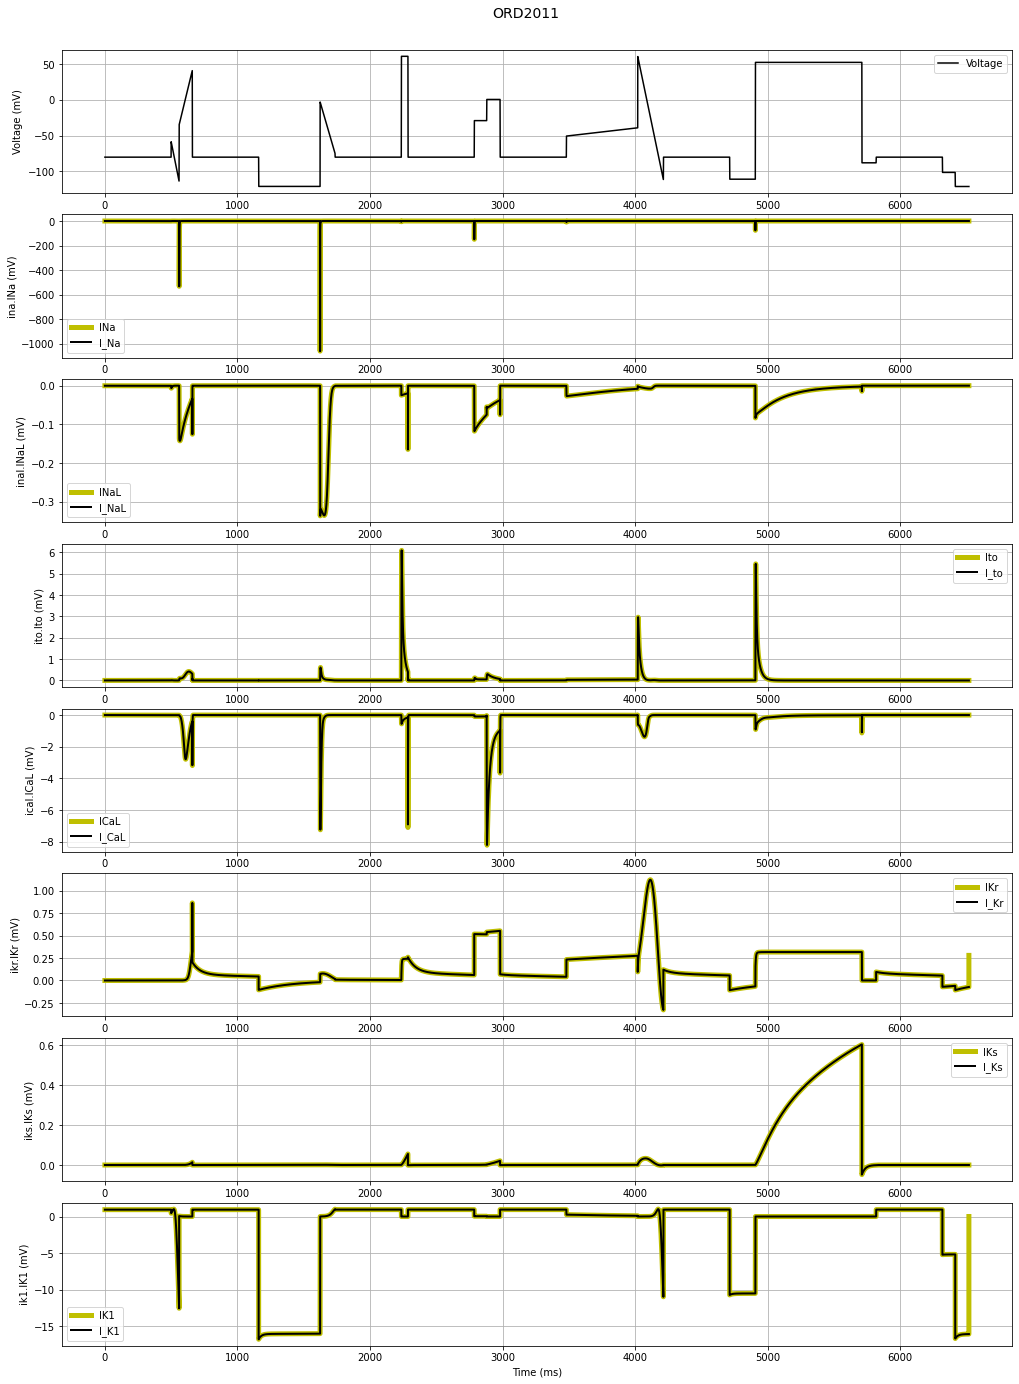

In [7]:
'''
Plot
'''
fig, axes = plt.subplots(8,1, figsize=(15,20))    
fig.suptitle(model_scipy.name, fontsize=14)
for i, name in enumerate(['Voltage'] + current_li):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    axes[i].set_xlabel('Time (ms)')       
    axes[i].set_ylabel(f'{name} (mV)')  
    
    if i==0:
        axes[i].plot( t_eval, [protocol.get_voltage_at_time(t) for t in t_eval], label=name, color='k')           
    else:
        name = name.split('.')[1]
        name2 = name[0]+'_' + name[1:]        
        axes[i].plot( d_myokit['engine.time'], sim_myokit.current_response_info.get_current([name]), label=name, color='y', linewidth=5) 
        axes[i].plot( sol_scipy.t, model_scipy.current_response_info.get_current([name2]), label=name2, color='k', linewidth=2)   
    axes[i].legend()
    axes[i].grid()

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig(os.path.join('Results', "ORD2011-VC.jpg"), dpi=100)

In [8]:
print("Complete")

Complete
